In [42]:
import os
import glob
import re
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from rasterio.features import geometry_mask

In [40]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Pair image and shapefile paths based on filenames
def pair_files(image_paths, shapefile_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if not matching_shapefiles:
            print(f"No matching shapefile found for {image_path}")
            continue

        shapefile_path = matching_shapefiles[0]
        file_pairs[image_path] = shapefile_path
    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths)

# Pair new walrus images with existing images
def pair_walrus_files(new_walrus_paths, image_paths):
    for walrus_path in new_walrus_paths:
        island, date = extract_island_and_date(os.path.basename(walrus_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {walrus_path}")
            continue

        matching_images = [image for image in image_paths if island in image and date in image]
        if not matching_images:
            print(f"No matching image found for {walrus_path}")
            continue

        image_path = matching_images[0]
        file_pairs[image_path] = walrus_path

pair_walrus_files(new_walrus_paths, image_paths + unlabeled_image_paths)

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel.astype(np.float32))  # Ensure features are floats
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

# Extract features and labels for all image-shapefile pairs
def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, shapefile_path in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


In [44]:
# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df['encoded_labels'].values for cls in [le.transform(['walrus_pure'])[0], le.transform(['walrus_mixed'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset)
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, train_df['encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values

# Calculate and print the number of pixels for each class in the training and test datasets
def print_class_distribution(df, name):
    class_counts = df['encoded_labels'].value_counts()
    class_names = le.inverse_transform(class_counts.index)
    print(f"\n{name} Class Distribution:")
    for class_name, count in zip(class_names, class_counts):
        print(f"{class_name}: {count}")

# Calculate class distributions
print_class_distribution(train_df, "Training")
print_class_distribution(test_df, "Test")

# Calculate and print the number of pixels from each island in the test dataset
def print_island_distribution(df):
    islands = df['image_name'].apply(lambda x: extract_island_and_date(os.path.basename(x))[0])
    island_counts = islands.value_counts()
    print("\nTest Dataset Island Distribution:")
    for island, count in island_counts.items():
        print(f"{island}: {count}")

# Print image names used in the test data and the number of pixels from each island
def print_test_images_info(df):
    print("\nTest Dataset Image Names and Pixel Counts:")
    image_names = df['image_name'].unique()
    for image_name in image_names:
        image_pixel_count = (df['image_name'] == image_name).sum()
        print(f"Image: {os.path.basename(image_name)}, Pixels: {image_pixel_count}")

# Print island distribution and test images info
print_island_distribution(test_df)
print_test_images_info(test_df)


Training Class Distribution:
ocean: 425793
ice: 188757
rock: 72306
freshwater: 25954
walrus_mixed: 822
walrus_pure: 159

Test Class Distribution:
ocean: 106448
ice: 47189
rock: 18076
freshwater: 6489
walrus_mixed: 206
walrus_pure: 40

Test Dataset Island Distribution:
buch: 87279
tor: 43788
pal: 33875
moff: 13501
sars: 5

Test Dataset Image Names and Pixel Counts:
Image: buch_20230714_image.tif, Pixels: 22
Image: buch_20230720_image.tif, Pixels: 37357
Image: buch_20230731_image.tif, Pixels: 34908
Image: buch_20230923_image.tif, Pixels: 14967
Image: moff_20230717_image.tif, Pixels: 13501
Image: pal_20230714_image.tif, Pixels: 12658
Image: pal_20230720_image.tif, Pixels: 5639
Image: pal_20230726_image.tif, Pixels: 15578
Image: sars_20230714_image.tif, Pixels: 2
Image: sars_20230803_image.tif, Pixels: 3
Image: tor_20230801_image.tif, Pixels: 14606
Image: tor_20230824_image.tif, Pixels: 12206
Image: tor_20230901_image.tif, Pixels: 16905
Image: tor_20230902_image.tif, Pixels: 23
Image: buc

In [45]:
# Train the k-NN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Save the model
model_filename = "k-nn20.joblib"
joblib.dump(model, model_filename)

KNeighborsClassifier()

k-NN Model
Accuracy: 0.9882766968528647
Precision: 0.9882252086801762
Recall: 0.9882766968528647
F1 Score: 0.9881523063638458
Cohen's Kappa: 0.9791536212025738

Classification Report:
              precision    recall  f1-score   support

  freshwater       0.89      0.90      0.89      6489
         ice       0.98      0.99      0.98     47189
       ocean       1.00      1.00      1.00    106448
        rock       0.99      0.98      0.98     18076
walrus_mixed       0.88      0.44      0.59       206
 walrus_pure       0.73      0.47      0.58        40

    accuracy                           0.99    178448
   macro avg       0.91      0.80      0.84    178448
weighted avg       0.99      0.99      0.99    178448


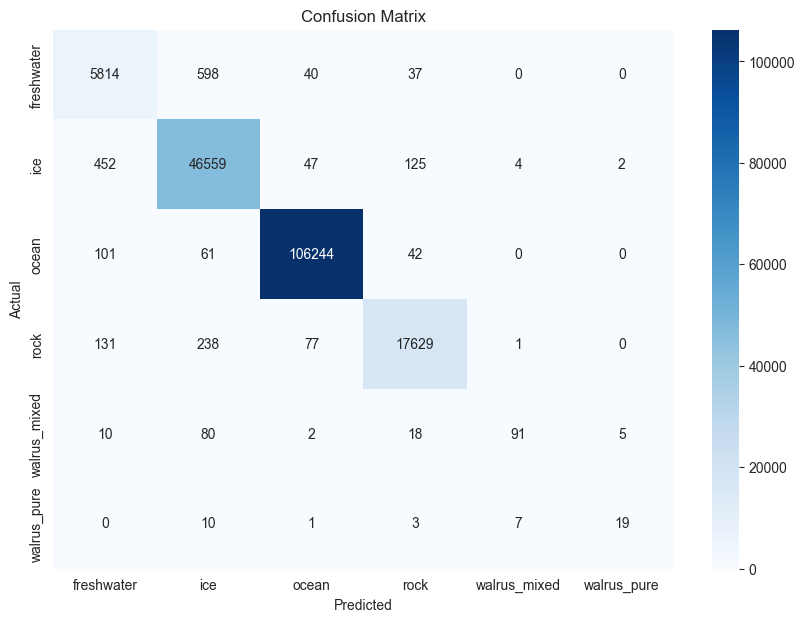

In [46]:
# Evaluate the k-NN model
y_pred = knn.predict(X_test)

# Calculate Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

# Print Metrics
print("k-NN Model")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


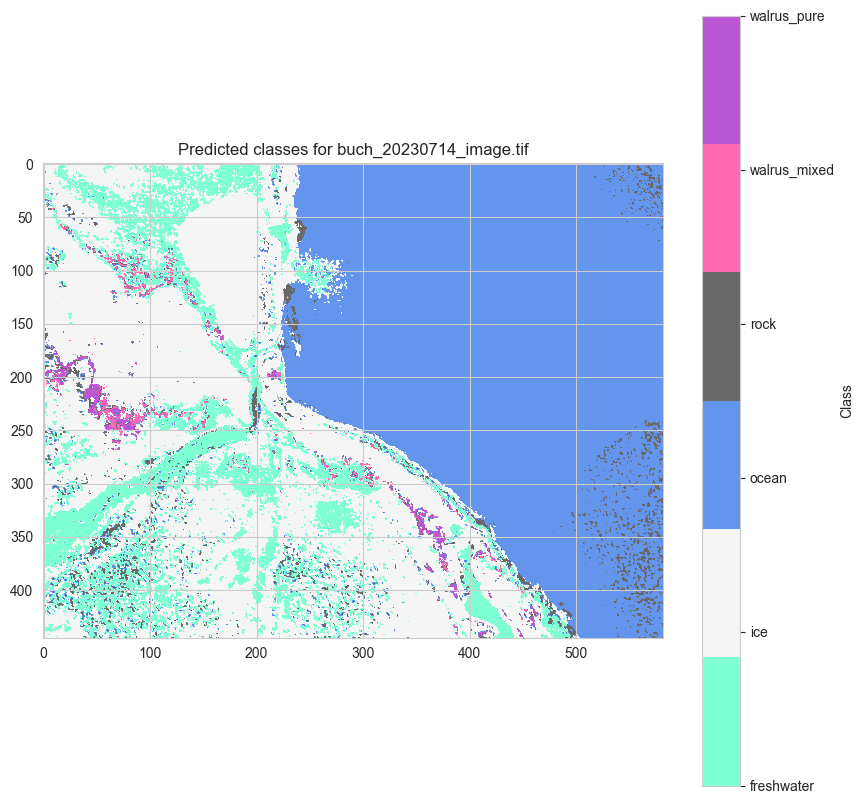

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


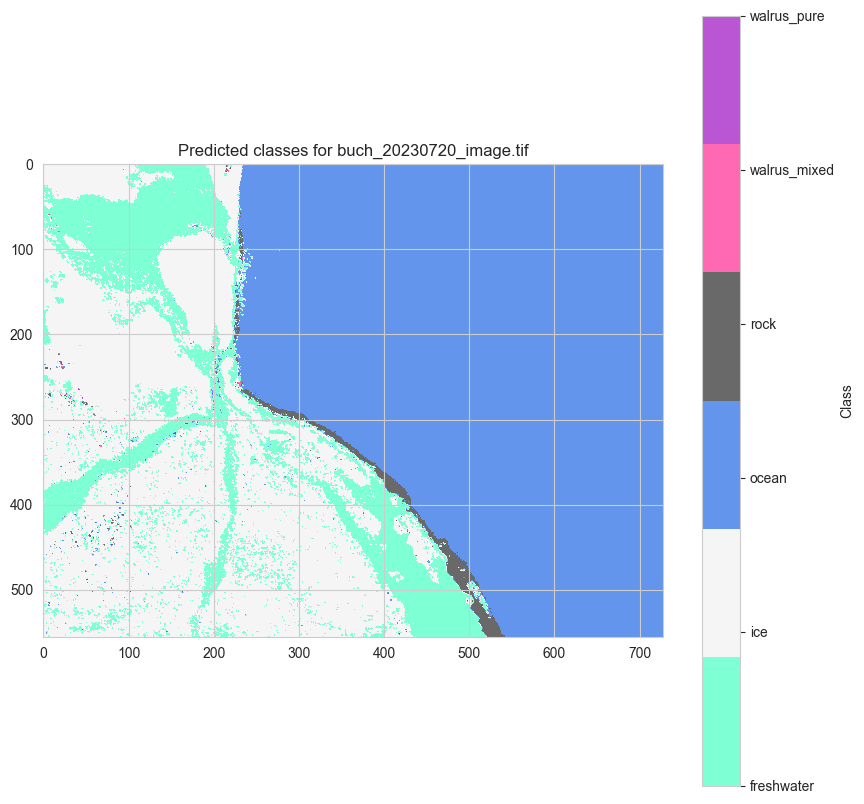

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


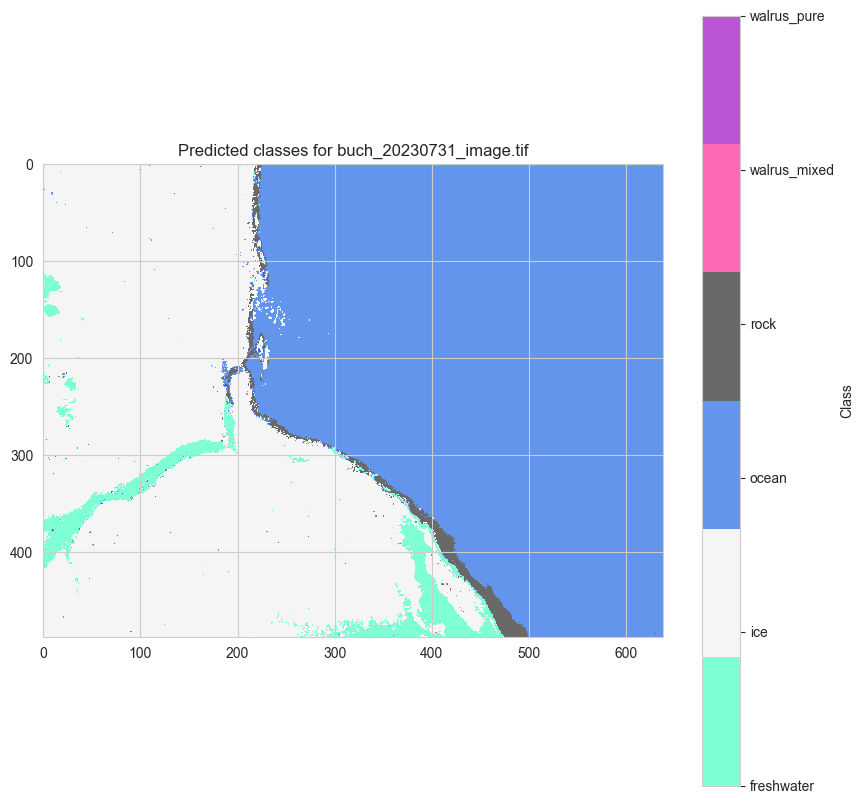

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean']


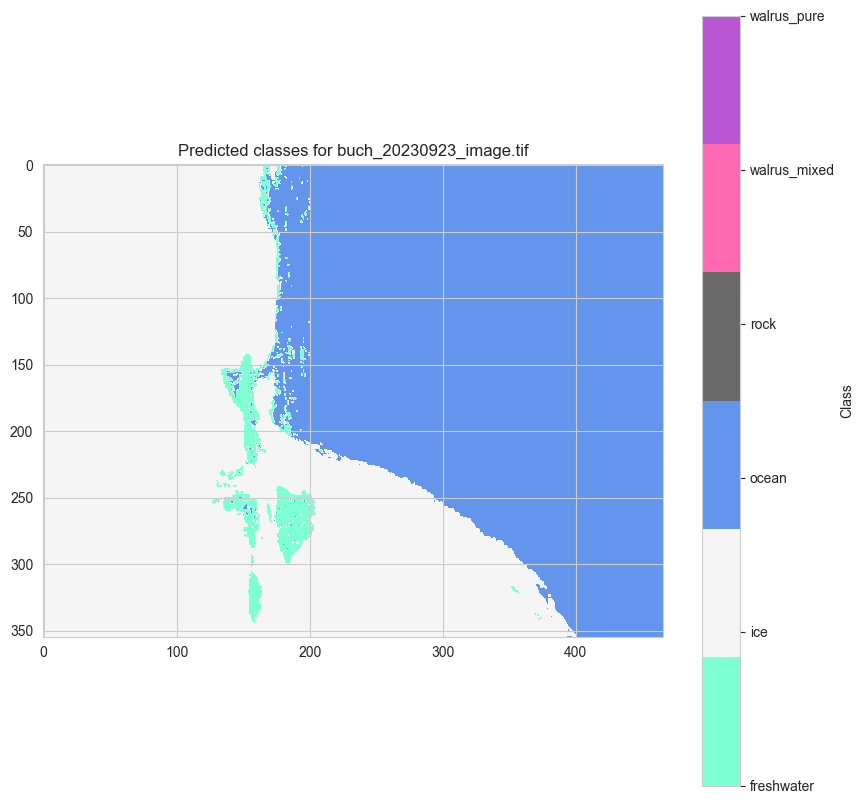

Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


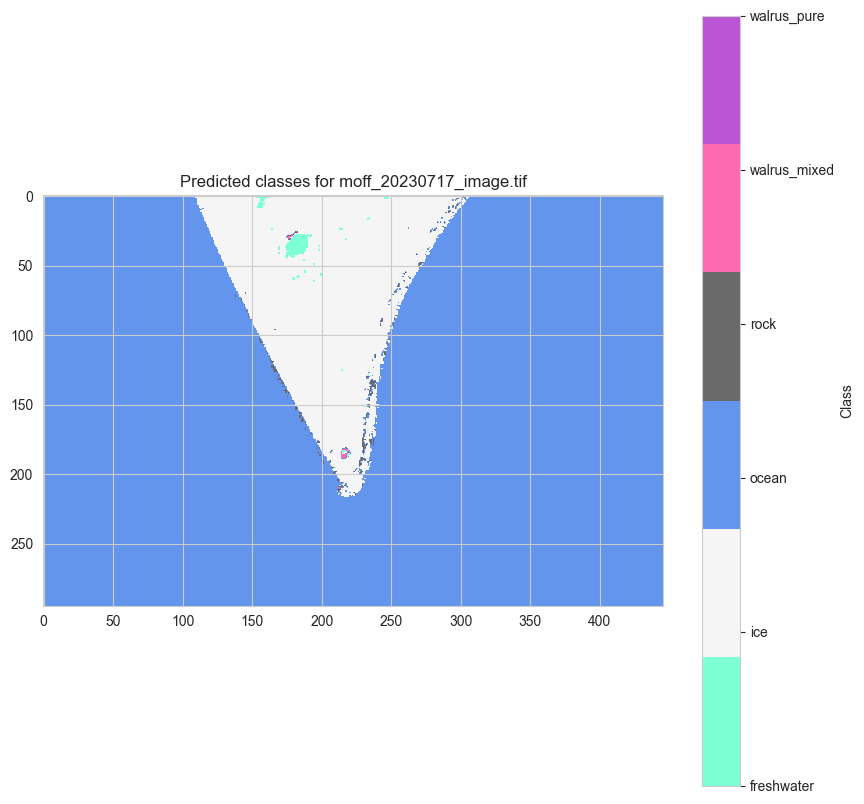

Labels present in pal_20230714_image.tif: ['ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


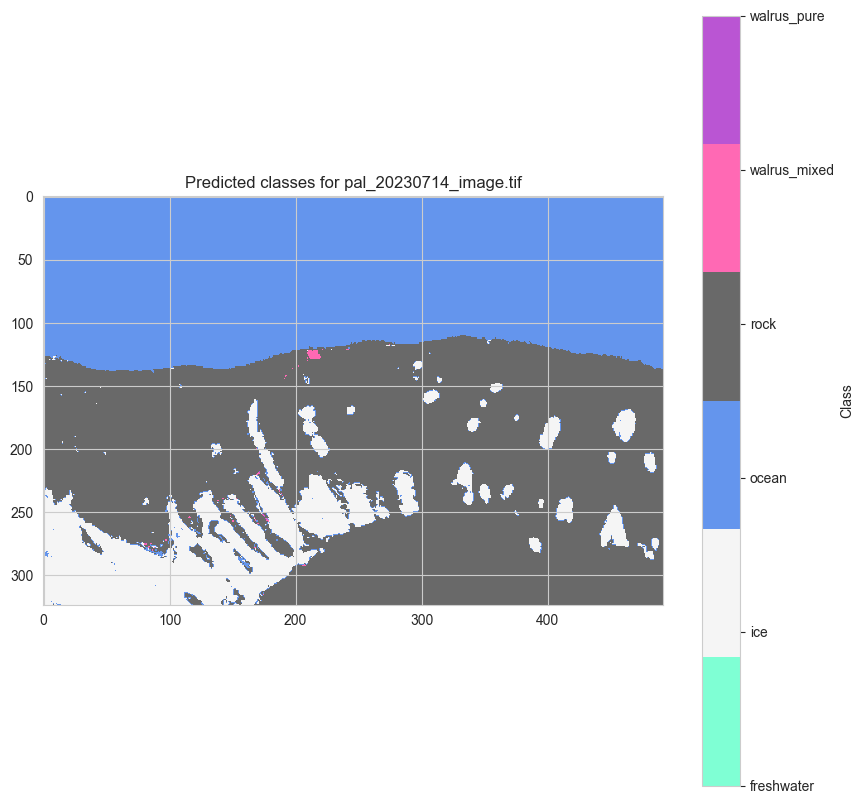

Labels present in pal_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


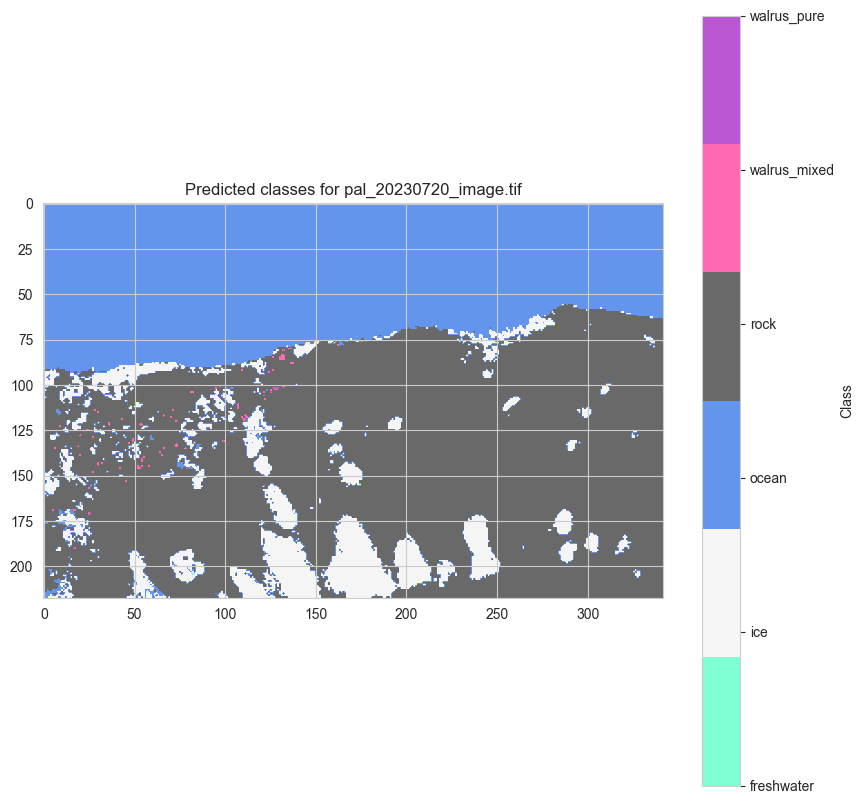

Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


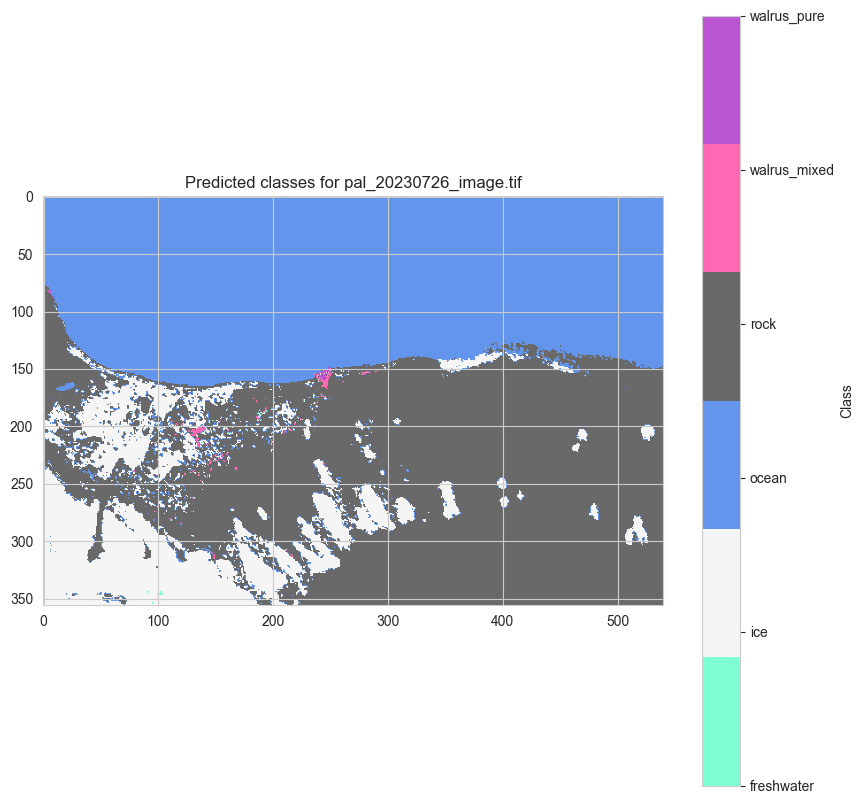

Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


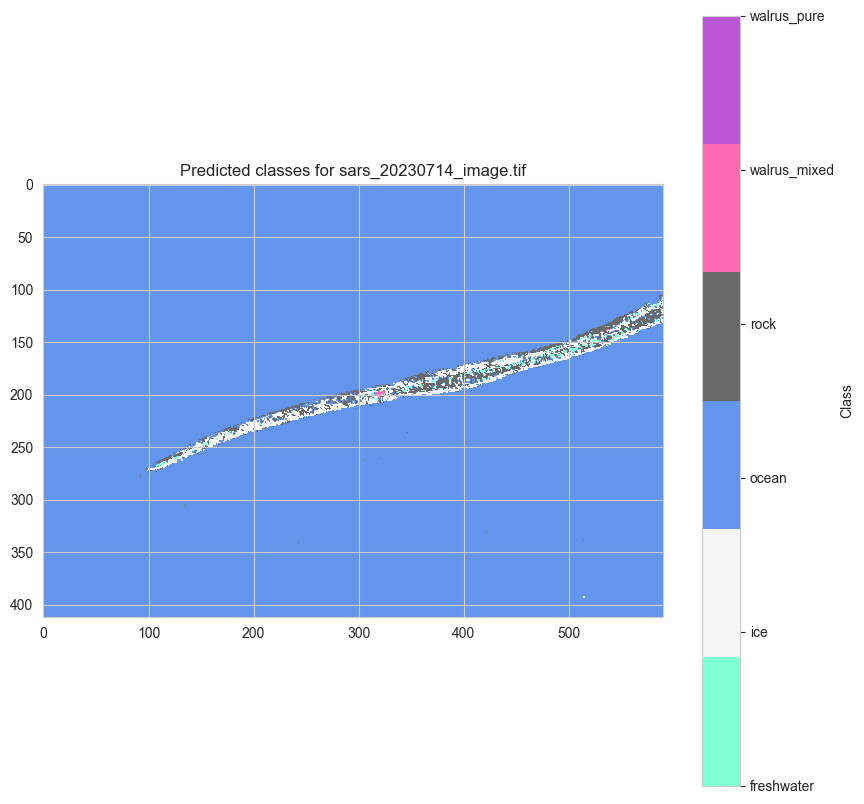

Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


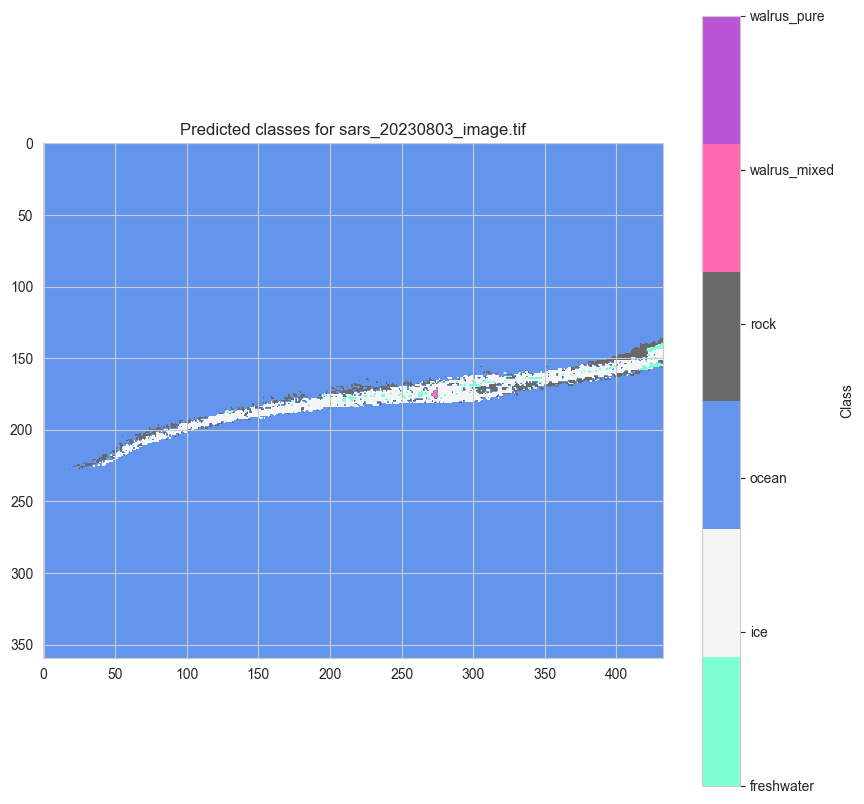

Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


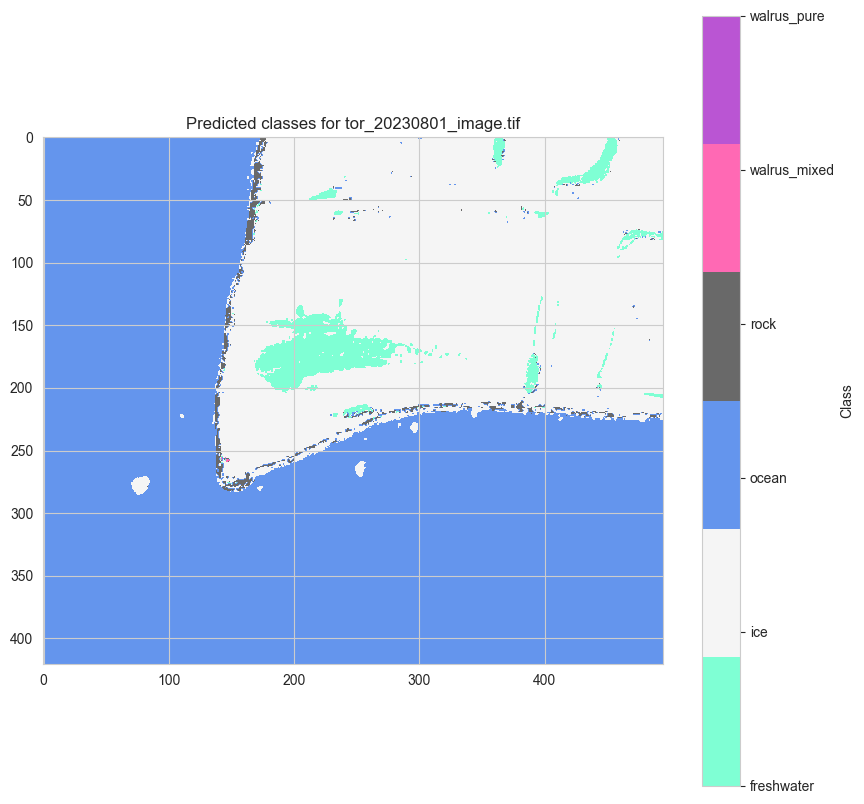

Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


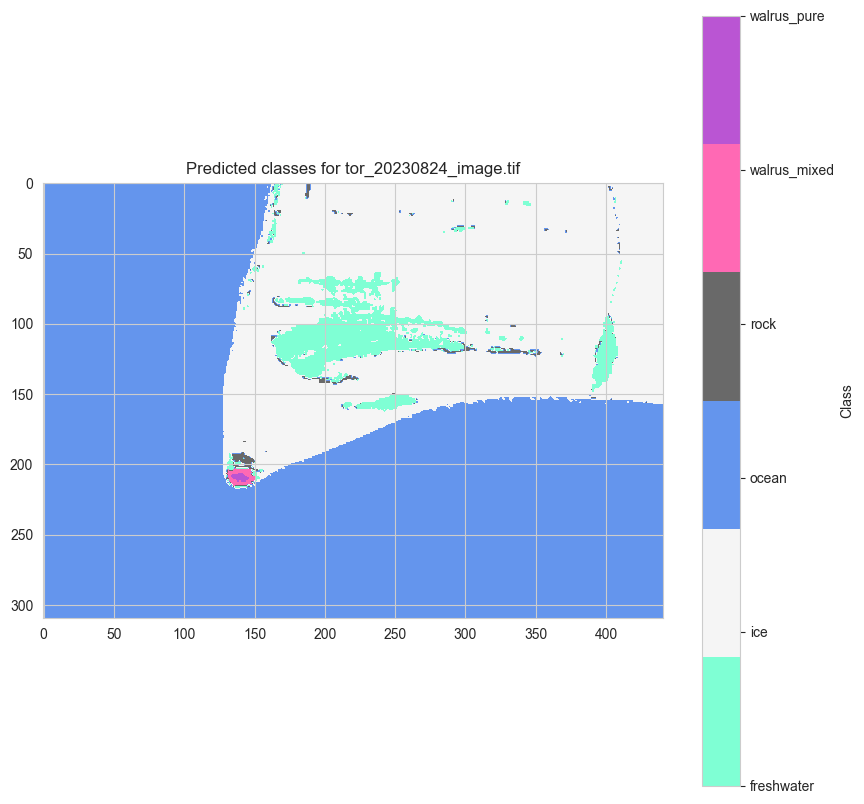

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


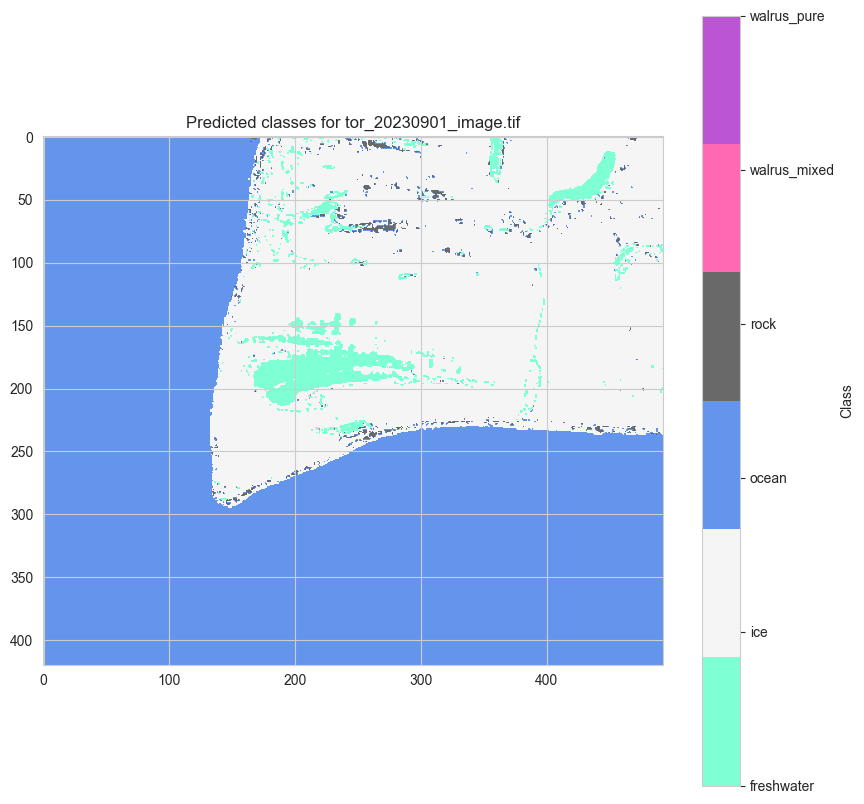

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


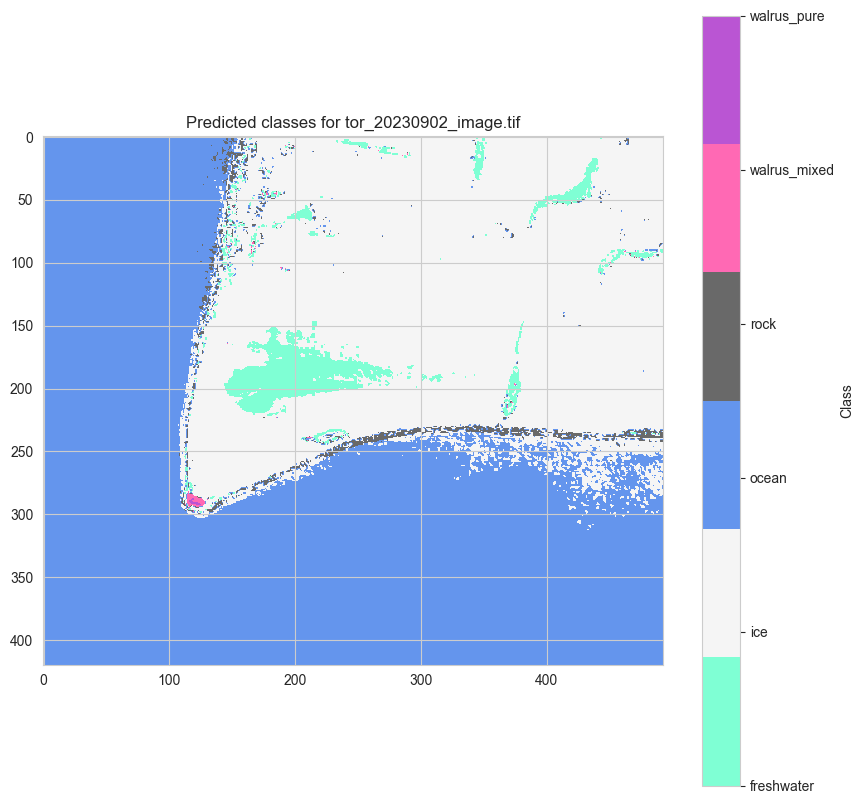

Labels present in buch_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


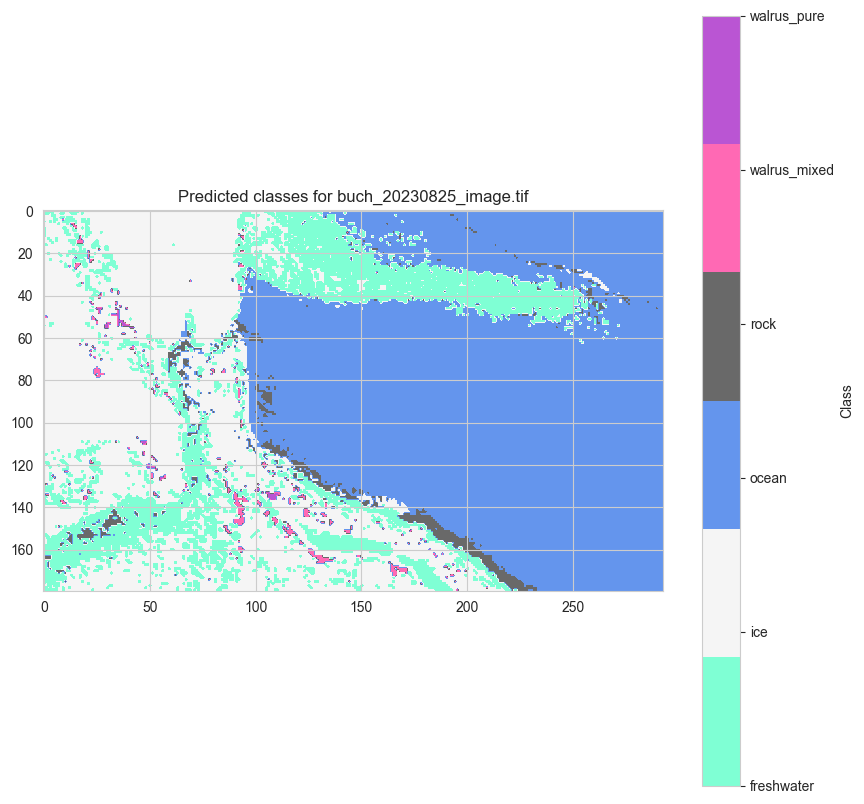

Labels present in buch_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


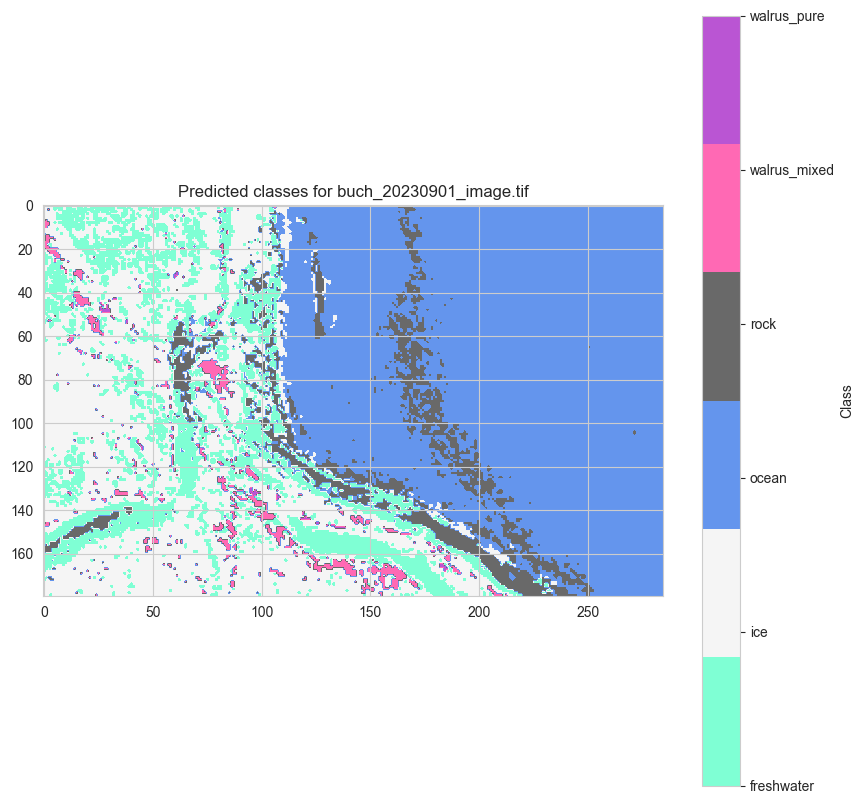

Labels present in tor_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


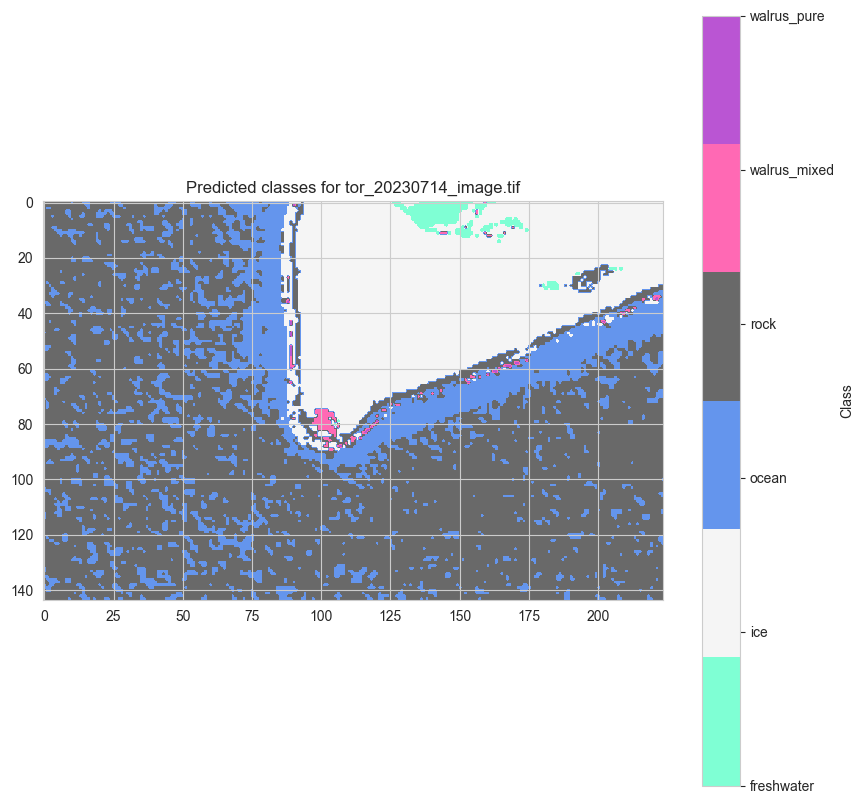

Labels present in tor_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


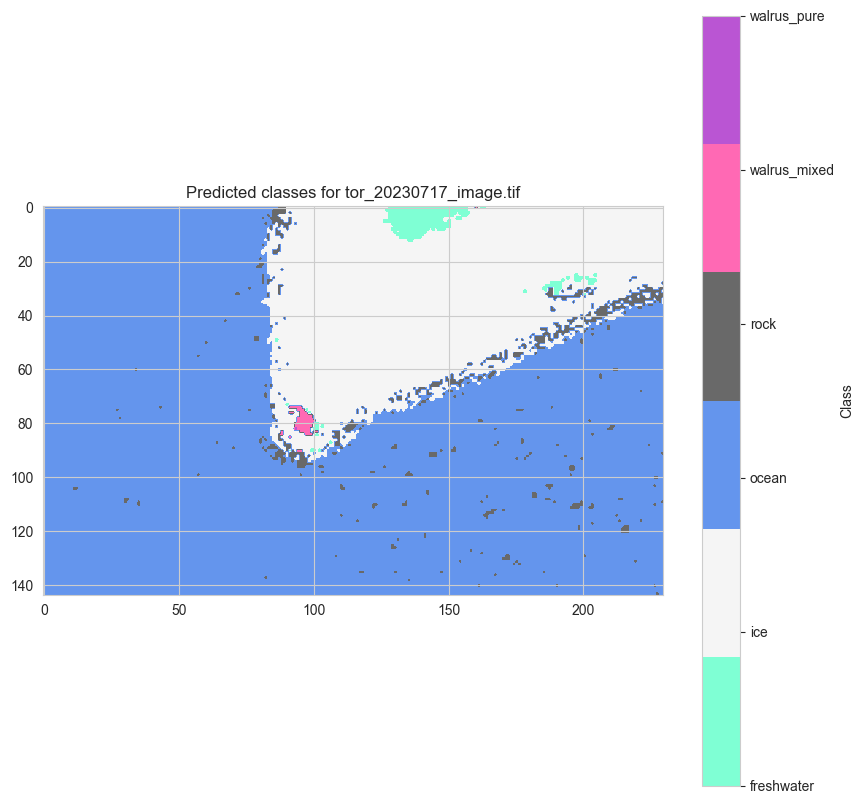

Labels present in tor_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


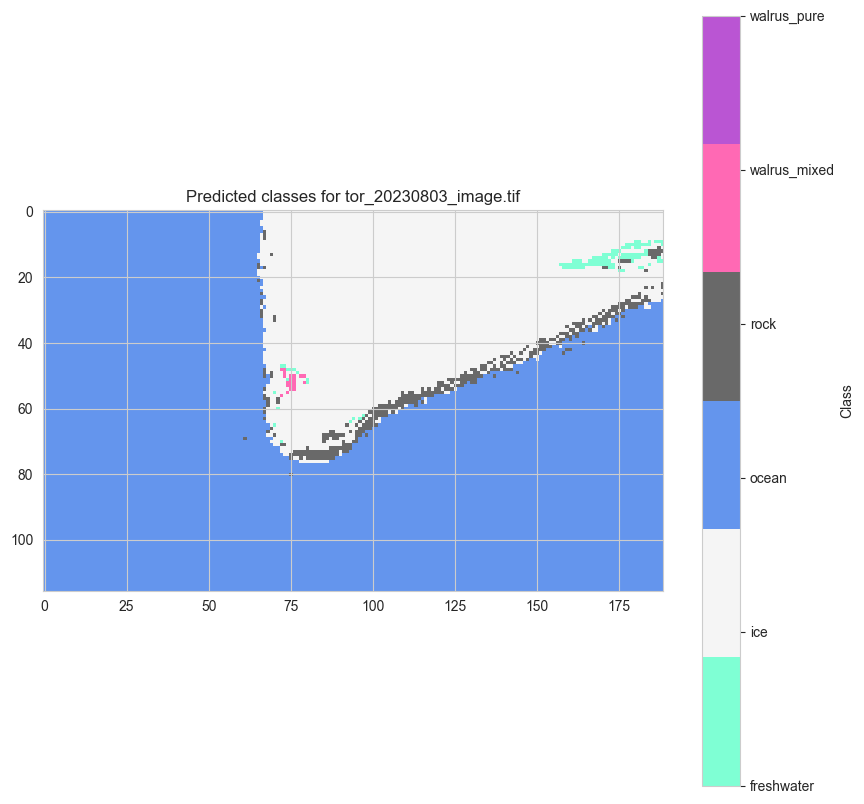

Labels present in tor_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


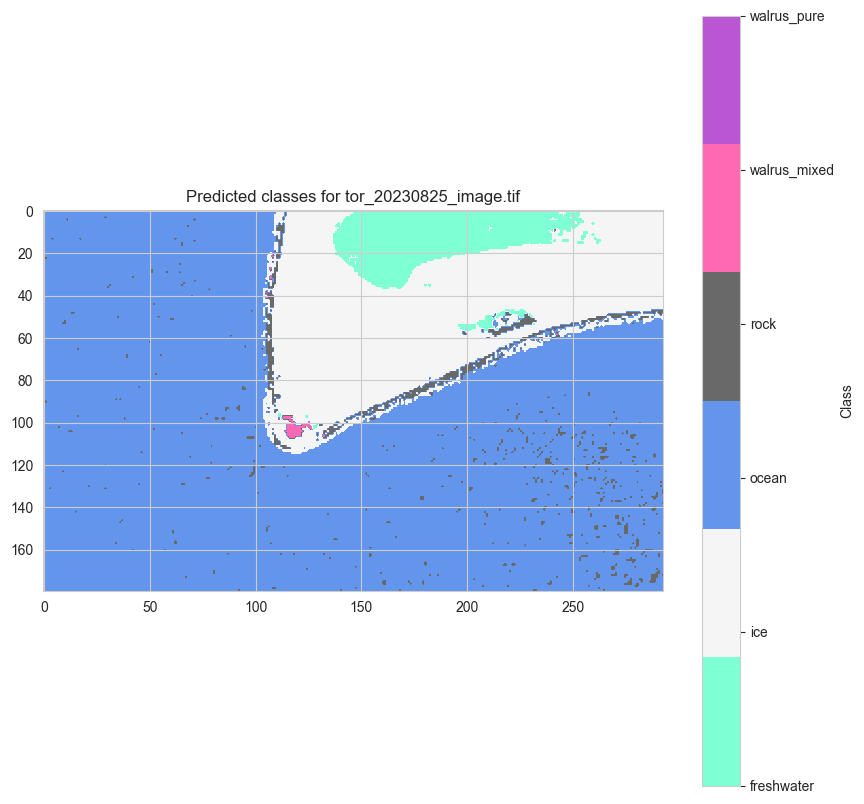

In [47]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

# Predict classes for images with attached shapefiles
predicted_images = {}
for image_path, shapefile in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, knn)

# Define a color map for the labels
label_colors = {
    'freshwater': 'aquamarine',
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()

In [3]:
import os
import glob
import re
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [17]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

def pair_training_files(image_paths, shapefile_paths):
    training_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if matching_shapefiles:
            training_pairs[image_path] = matching_shapefiles[0]

    return training_pairs

def pair_validation_files(unlabeled_image_paths, walrus_paths):
    validation_pairs = {}
    for image_path in unlabeled_image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_walrus = [walrus for walrus in walrus_paths if island in walrus and date in walrus]
        if matching_walrus:
            validation_pairs[image_path] = matching_walrus[0]
        else:
            validation_pairs[image_path] = None  # Include images without walrus shapefiles

    return validation_pairs

training_pairs = pair_training_files(image_paths, shapefile_paths)
validation_pairs = pair_validation_files(unlabeled_image_paths, new_walrus_paths)

def extract_features_labels(image_path, general_shapefile, walrus_shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []
    img_name = []

    # Process general shapefile
    if general_shapefile:
        gdf = gpd.read_file(general_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel.astype(np.float32))  # Ensure features are floats
                labels.append(row['label'])
                img_name.append(image_path)

    # Process walrus shapefile
    if walrus_shapefile:
        gdf = gpd.read_file(walrus_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel.astype(np.float32))  # Ensure features are floats
                labels.append(row['label'])
                img_name.append(image_path)

    features, labels, img_name = np.array(features), np.array(labels), np.array(img_name)

    # Debugging print statements
    print(f"Extracted {features.shape[0]} features, {labels.shape[0]} labels from {image_path}")

    return features, labels, img_name


def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []
    islands_included = set()

    for image_path, shapefile in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, shapefile, None)
        if img_features.size > 0:
            features.append(img_features)
            labels.append(img_labels)
            image_name.append(img_name)
            island, _ = extract_island_and_date(os.path.basename(image_path))
            islands_included.add(island)

    if features and labels:
        features = np.vstack(features)
        labels = np.hstack(labels)
        image_name = np.hstack(image_name)
    else:
        features = np.array(features)
        labels = np.array(labels)
        image_name = np.array(image_name)

    print(f"Total features: {features.shape}, Total labels: {labels.shape}, Total image names: {image_name.shape}")
    print(f"Islands included in the training set: {islands_included}")

    return features, labels, image_name

def count_pixels_per_class(labels):
    unique, counts = np.unique(labels, return_counts=True)
    class_counts = dict(zip(unique, counts))
    return class_counts

features, labels, image_name = get_dataset(training_pairs)

# Count the number of pixels in each class before training
class_counts = count_pixels_per_class(labels)
print("Number of pixels per class before training:")
for class_label, count in class_counts.items():
    print(f"{class_label}: {count}")

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})

X = dataset.iloc[:, :8].values  # Select only the first 8 columns (numeric features)
y = dataset['encoded_labels'].values

Extracted 118050 features, 118050 labels from C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230714_image.tif
Extracted 186702 features, 186702 labels from C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230720_image.tif
Extracted 174450 features, 174450 labels from C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230731_image.tif
Extracted 74527 features, 74527 labels from C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230923_image.tif
Extracted 67507 features, 67507 labels from C:\Users\Student\Documents\101_walrus_data\train\clipped_images\moff_20230717_image.tif
Extracted 63726 features, 63726 labels from C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pal_20230714_image.tif
Extracted 28744 features, 28744 labels from C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pal_20230720_image.tif
Extracted 78019 features, 78019 labels from C:\Users\Student\Documents\1

In [22]:
from sklearn.model_selection import RandomizedSearchCV, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import numpy as np


In [23]:
# Use only numeric features
X = dataset.iloc[:, :8].values
y = dataset['encoded_labels'].values.astype(int)

# Use a smaller subset of data if needed
X_subset, X_temp, y_subset, y_temp = train_test_split(X, y, train_size=0.2, stratify=y, random_state=42)

# Define the parameter space
param_dist = {'n_neighbors': np.arange(1, 21, 2)}  # Odd numbers from 1 to 19

# Define the scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Use RandomizedSearchCV with multiple scoring metrics
knn = KNeighborsClassifier()
random_search = RandomizedSearchCV(
    knn, 
    param_distributions=param_dist, 
    n_iter=5,  # Number of parameter settings sampled
    cv=5,      # Number of cross-validation folds
    scoring=scoring, 
    refit='f1',  # Use F1 score to select the best model
    n_jobs=-1    # Use all available cores
)

# Fit the random search
random_search.fit(X_subset, y_subset)

# Print results
print("Best parameters:", random_search.best_params_)
print("Best cross-validation scores:")
print(f"Accuracy: {random_search.cv_results_['mean_test_accuracy'][random_search.best_index_]:.4f}")
print(f"Precision: {random_search.cv_results_['mean_test_precision'][random_search.best_index_]:.4f}")
print(f"Recall: {random_search.cv_results_['mean_test_recall'][random_search.best_index_]:.4f}")
print(f"F1 Score: {random_search.cv_results_['mean_test_f1'][random_search.best_index_]:.4f}")


Best parameters: {'n_neighbors': 3}
Best cross-validation scores:
Accuracy: 0.9860
Precision: 0.9858
Recall: 0.9860
F1 Score: 0.9858


In [ ]:
# Use the best model to make predictions on the full dataset
best_knn = random_search.best_estimator_

# Perform cross-validation on the full dataset with the best model
cv_results = cross_validate(best_knn, X, y, cv=5, scoring=scoring)

print("\nFinal model performance (5-fold cross-validation on full dataset):")
print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std() * 2:.4f})")
print(f"Precision: {cv_results['test_precision'].mean():.4f} (+/- {cv_results['test_precision'].std() * 2:.4f})")
print(f"Recall: {cv_results['test_recall'].mean():.4f} (+/- {cv_results['test_recall'].std() * 2:.4f})")
print(f"F1 Score: {cv_results['test_f1'].mean():.4f} (+/- {cv_results['test_f1'].std() * 2:.4f})")

In [25]:
from sklearn.model_selection import RandomizedSearchCV, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Use only numeric features
X = dataset.iloc[:, :8].values
y = dataset['labels'].values

# Print unique labels
unique_labels = np.unique(y)
print("Unique labels in the dataset:", unique_labels)

# Ask user to specify the walrus label
walrus_label = input("Please enter the label that represents walrus in your dataset: ")

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Create binary labels for walrus class
y_walrus = (y == walrus_label).astype(int)

# Use a smaller subset of data if needed
X_subset, _, y_subset, _ = train_test_split(X, y_walrus, train_size=0.2, stratify=y_walrus, random_state=42)

# Define the parameter space
param_dist = {'n_neighbors': np.arange(1, 21, 2)}  # Odd numbers from 1 to 19

# Define the scoring metrics for walrus class
def walrus_precision(y_true, y_pred):
    return precision_score(y_true, y_pred, pos_label=1, zero_division=0)

def walrus_recall(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=1, zero_division=0)

def walrus_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label=1, zero_division=0)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(walrus_precision),
    'recall': make_scorer(walrus_recall),
    'f1': make_scorer(walrus_f1)
}

# Use RandomizedSearchCV with multiple scoring metrics
knn = KNeighborsClassifier()
random_search = RandomizedSearchCV(
    knn, 
    param_distributions=param_dist, 
    n_iter=5,  # Number of parameter settings sampled
    cv=5,      # Number of cross-validation folds
    scoring=scoring, 
    refit='f1',  # Use F1 score to select the best model
    n_jobs=-1    # Use all available cores
)

# Fit the random search
random_search.fit(X_subset, y_subset)

# Print results
print("Best parameters:", random_search.best_params_)
print(f"Best cross-validation scores for {walrus_label} class:")
print(f"Accuracy: {random_search.cv_results_['mean_test_accuracy'][random_search.best_index_]:.4f}")
print(f"Precision: {random_search.cv_results_['mean_test_precision'][random_search.best_index_]:.4f}")
print(f"Recall: {random_search.cv_results_['mean_test_recall'][random_search.best_index_]:.4f}")
print(f"F1 Score: {random_search.cv_results_['mean_test_f1'][random_search.best_index_]:.4f}")



Unique labels in the dataset: ['freshwater' 'ice' 'ocean' 'rock' 'walrus_mixed' 'walrus_pure']
Best parameters: {'n_neighbors': 5}
Best cross-validation scores for walrus_pure, walrus_mixed class:
Accuracy: 1.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


In [26]:
# Use the best model to make predictions on the full dataset
best_knn = random_search.best_estimator_

# Perform cross-validation on the full dataset with the best model
cv_results = cross_validate(best_knn, X, y_walrus, cv=5, scoring=scoring)

Labels present in Predicted labels - buch_20230714_image.tif: ['freshwater']


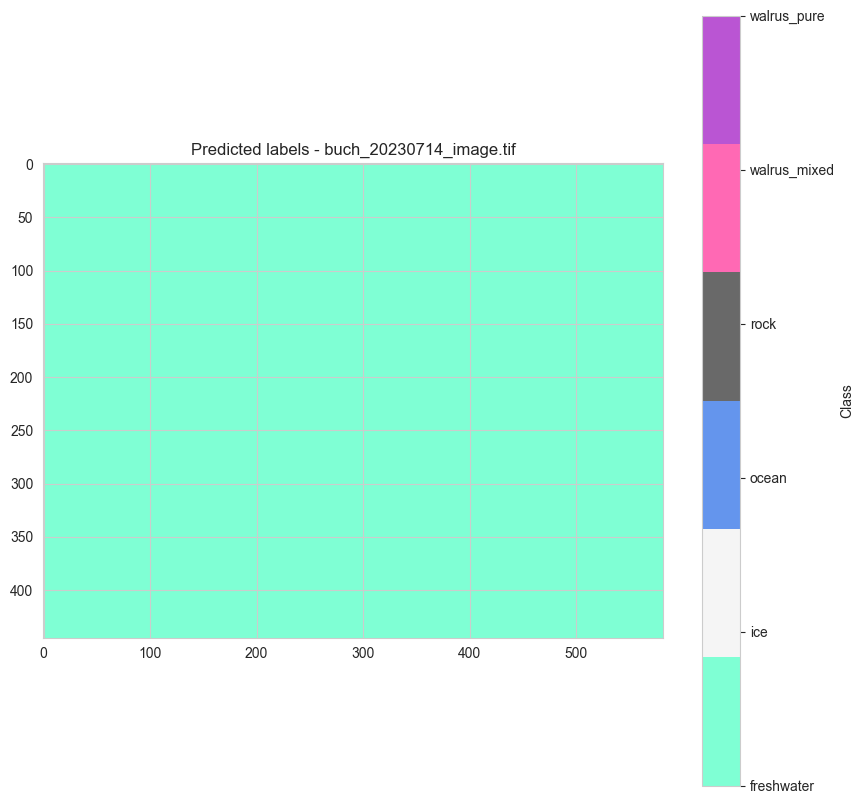

Labels present in Predicted labels - buch_20230720_image.tif: ['freshwater']


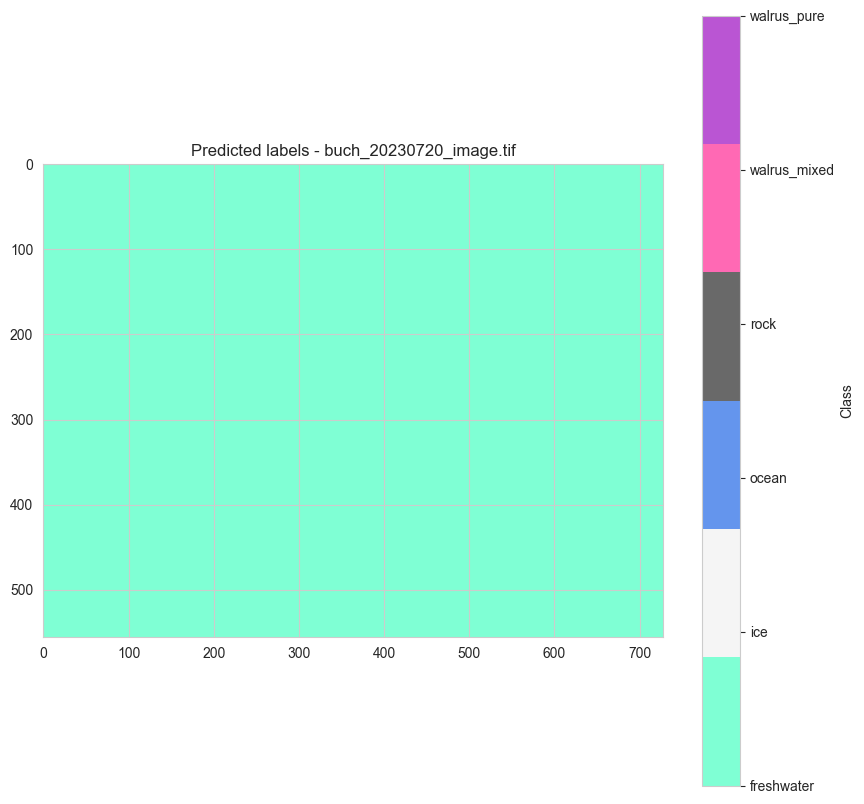

Labels present in Predicted labels - buch_20230731_image.tif: ['freshwater']


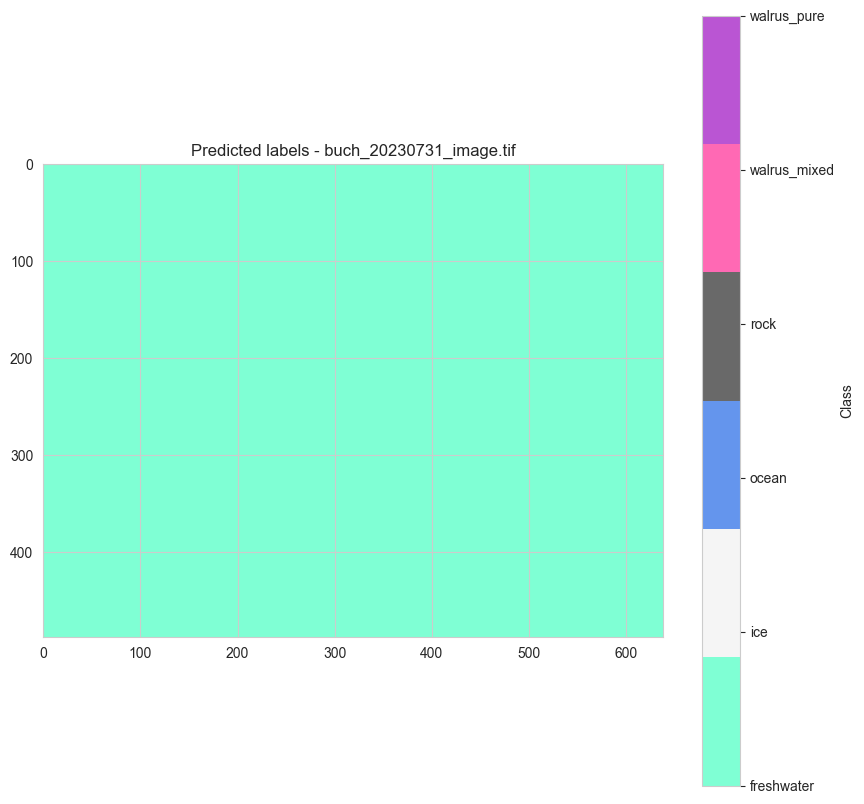

Labels present in Predicted labels - buch_20230923_image.tif: ['freshwater']


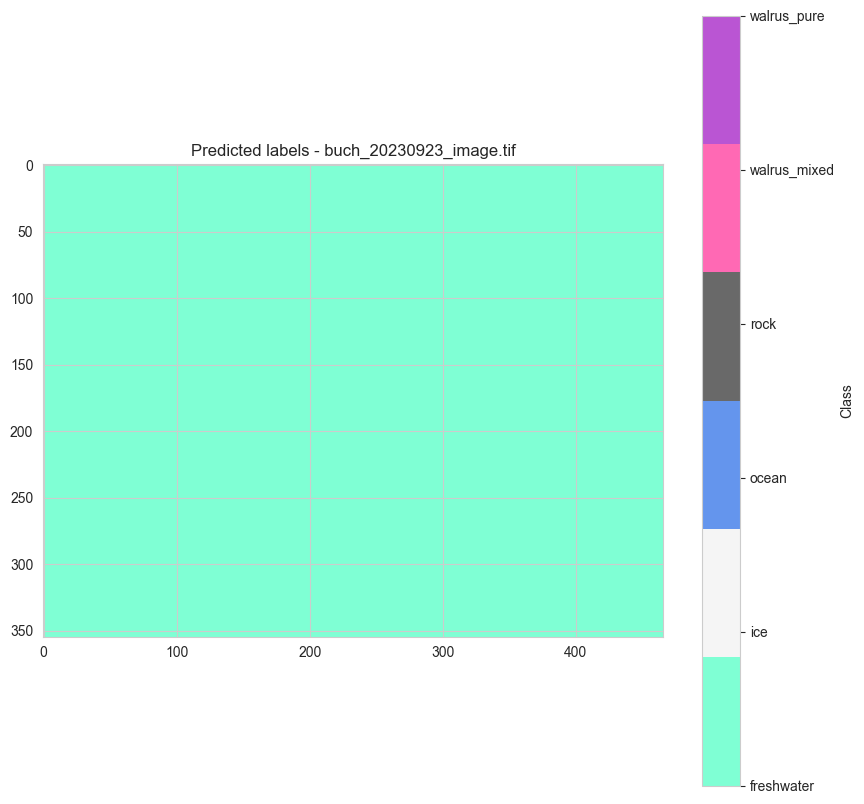

Labels present in Predicted labels - moff_20230717_image.tif: ['freshwater']


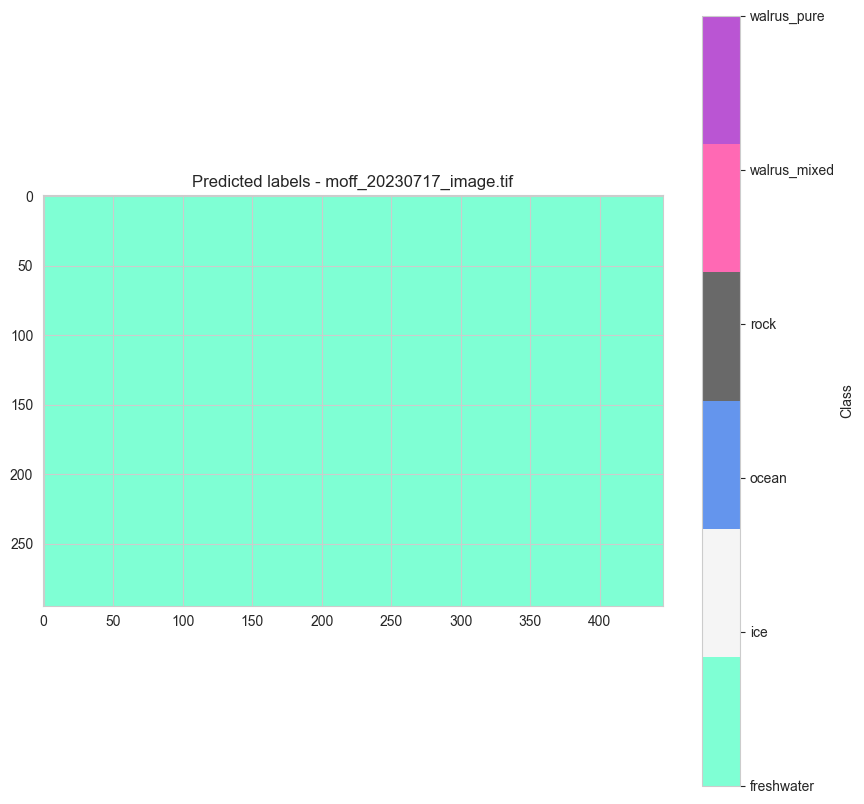

Labels present in Predicted labels - pal_20230714_image.tif: ['freshwater']


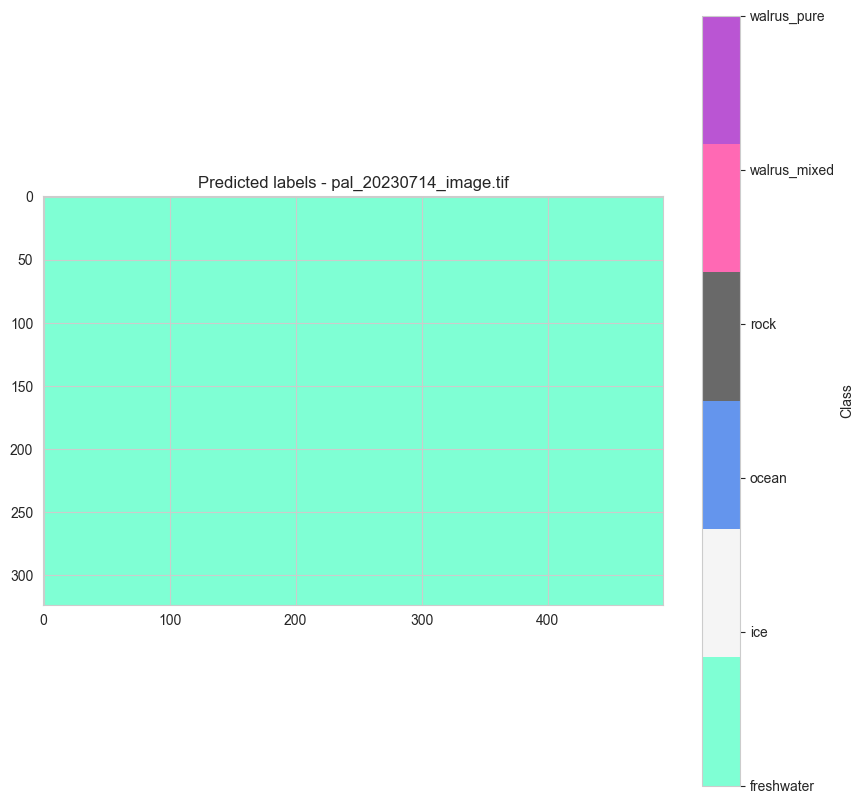

Labels present in Predicted labels - pal_20230720_image.tif: ['freshwater']


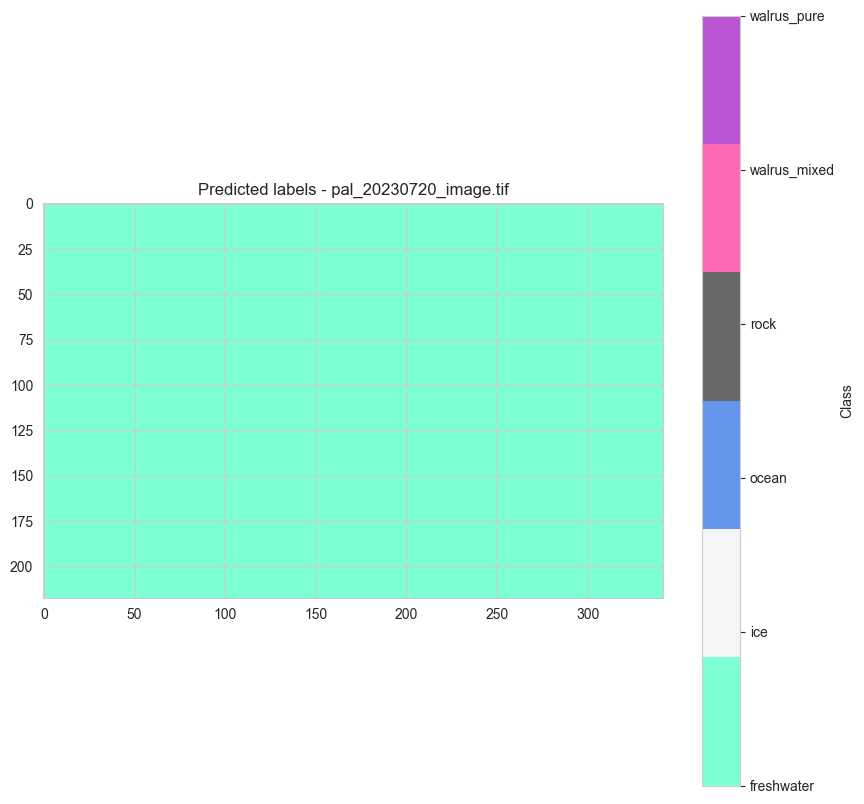

Labels present in Predicted labels - pal_20230726_image.tif: ['freshwater']


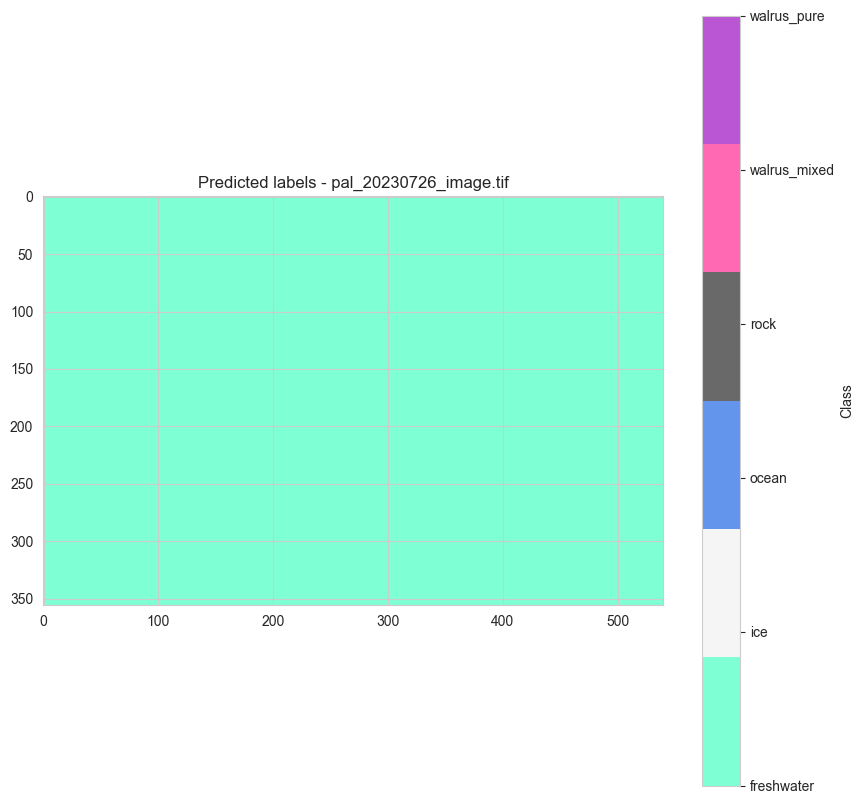

Labels present in Predicted labels - sars_20230714_image.tif: ['freshwater']


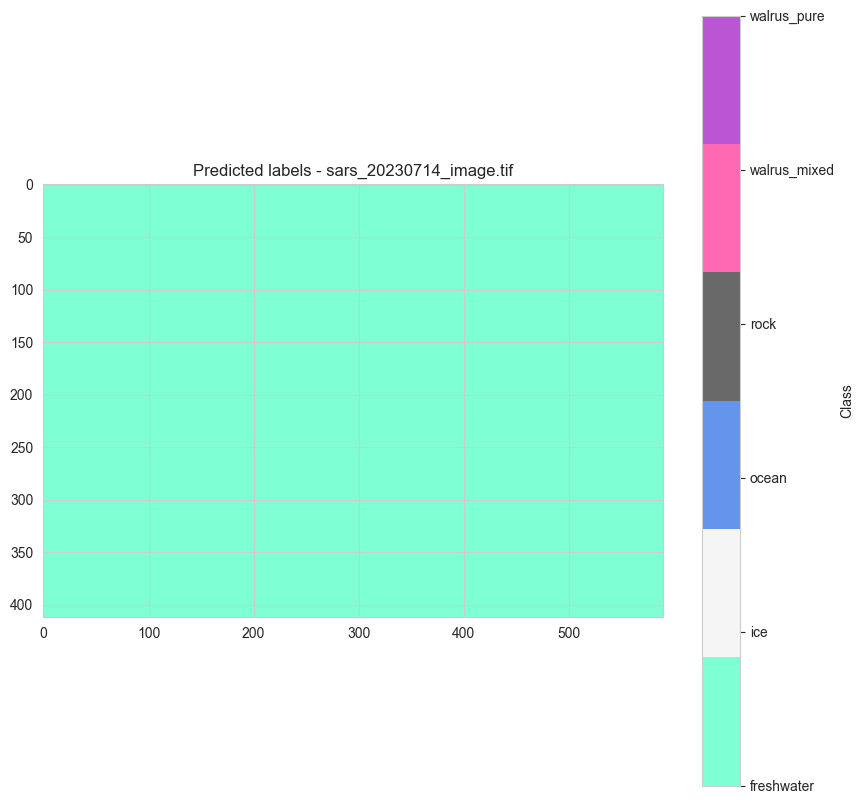

Labels present in Predicted labels - sars_20230803_image.tif: ['freshwater']


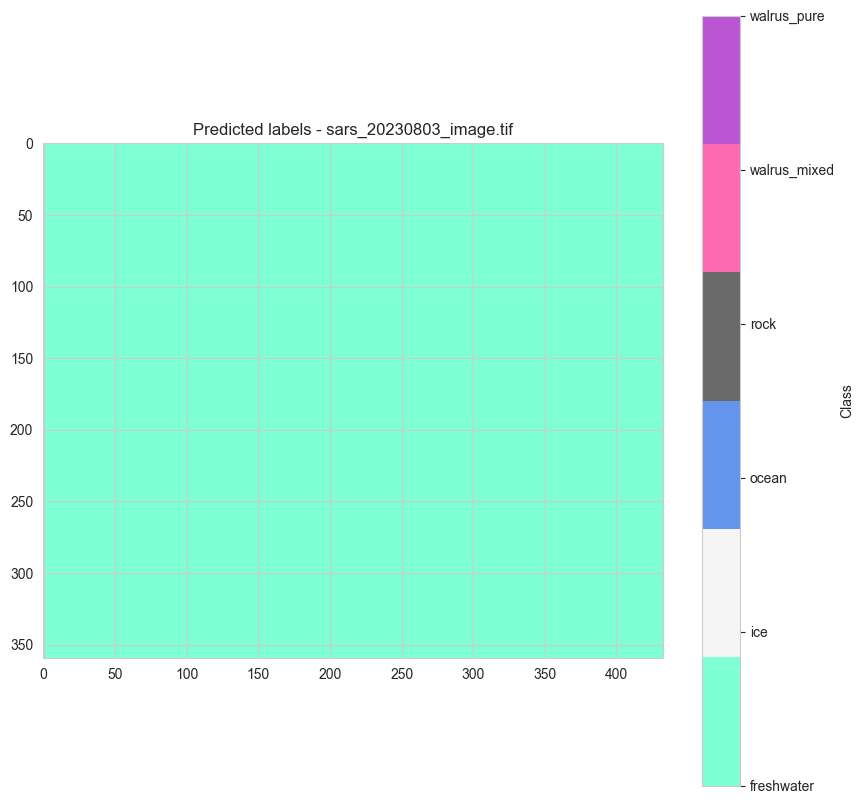

Labels present in Predicted labels - tor_20230801_image.tif: ['freshwater']


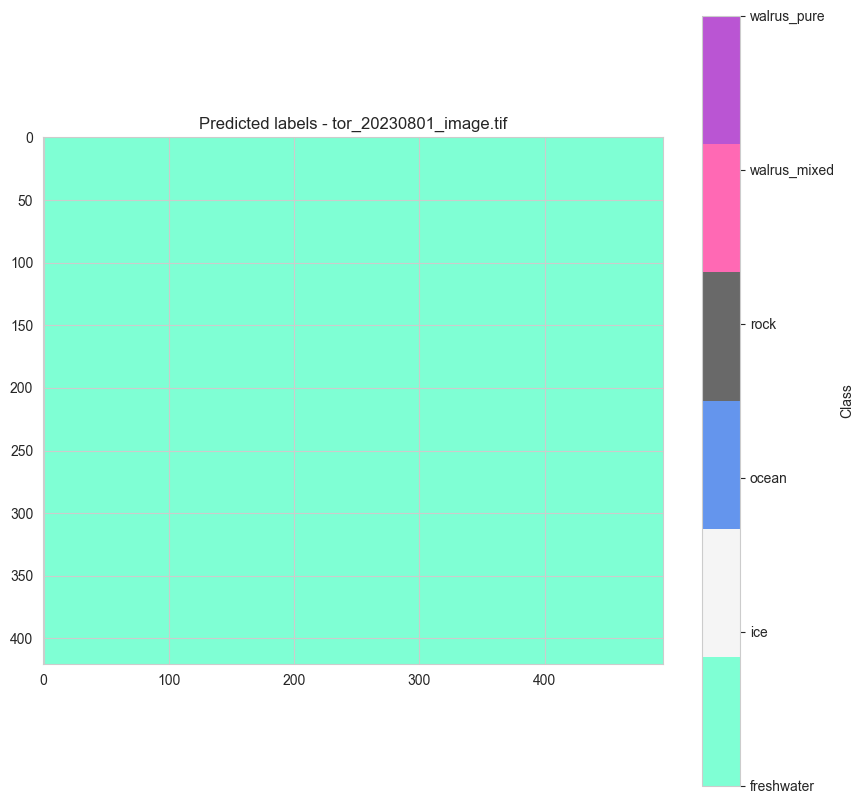

Labels present in Predicted labels - tor_20230824_image.tif: ['freshwater']


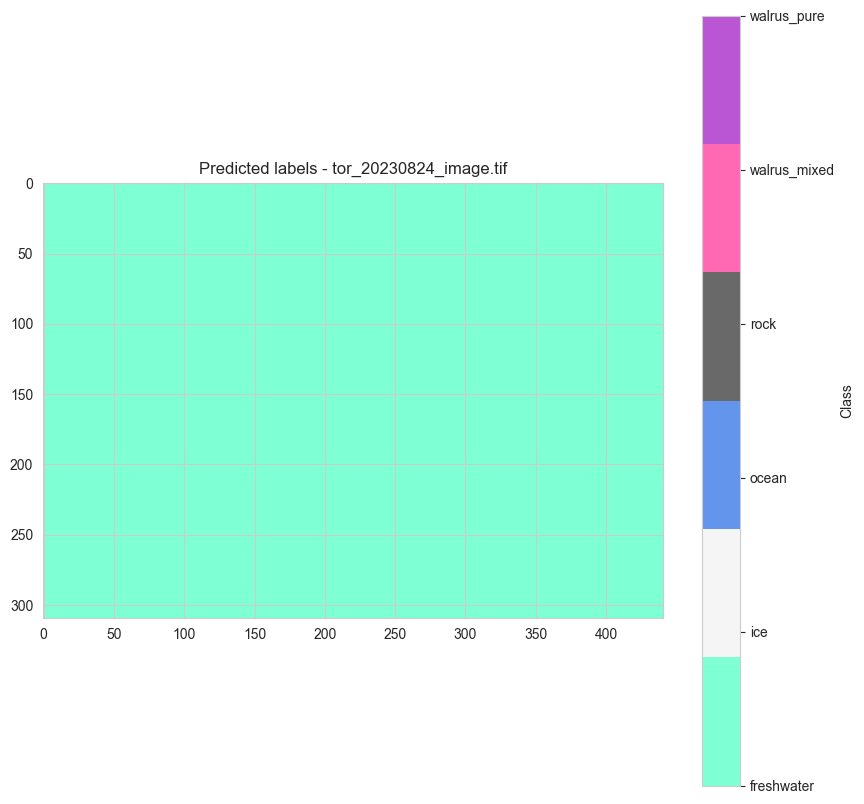

Labels present in Predicted labels - tor_20230901_image.tif: ['freshwater']


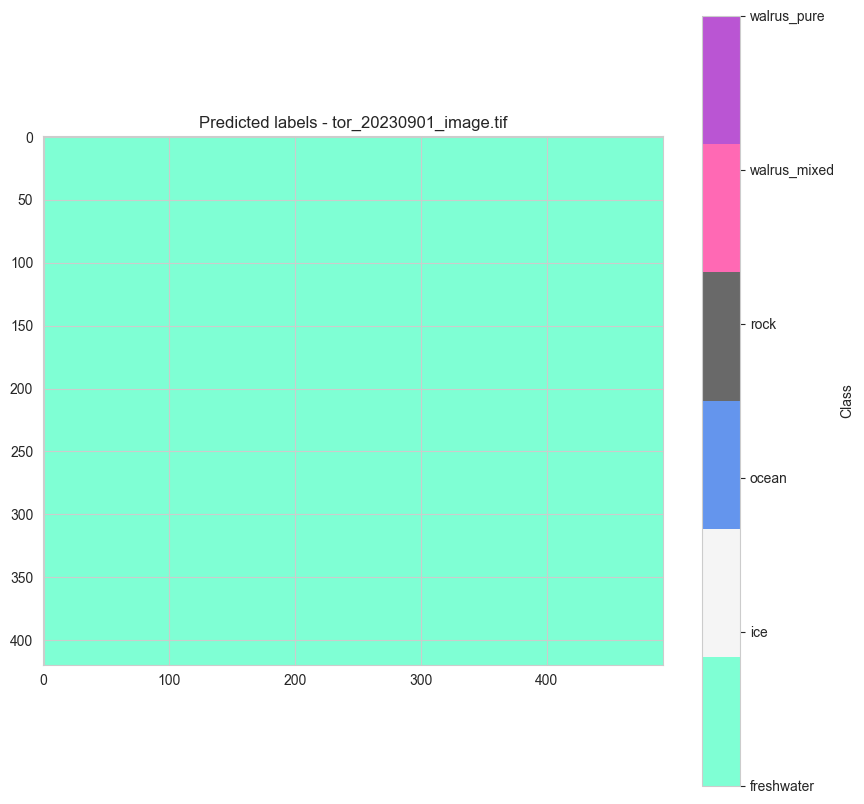


KeyboardInterrupt



In [27]:
# Function to read and prepare image data
def read_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        return image_reshaped, (src.height, src.width)

# Function to predict classes for a given image
def predict_image(image_path, model):
    image_data, (height, width) = read_image(image_path)
    predictions = model.predict(image_data)
    return predictions.reshape((height, width))

# Define a color map for the labels
label_colors = {
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

# Create a LabelEncoder and fit it to your labels
le = LabelEncoder()
le.fit(dataset['labels'])  # Make sure 'dataset' contains all your labels

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot function
def plot_image(image, title):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    # Highlight the labels present in the current image
    unique_labels = np.unique(image)
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {title}: {present_labels}")
    
    plt.show()

# Predict and plot images
for image_path, shapefile_path in training_pairs.items():
    # Predict labels
    predicted_image = predict_image(image_path, best_knn)
    
    # Plot predicted labels
    plot_image(predicted_image, f"Predicted labels - {os.path.basename(image_path)}")

    # If you have actual labels and want to plot them:
    # Uncomment and modify these lines based on how your actual labels are stored
    # with rasterio.open(shapefile_path) as src:
    #     actual_image = src.read(1)  # Modify this line if necessary
    # plot_image(actual_image, f"Actual labels - {os.path.basename(image_path)}")

print("Plotting complete.")